Some consideration before starting:
-Edit cifar10.py file, setting the directory where CIFAR10 dataset is located.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
batch_size = 64
cifar10 = CIFAR10(batch_size=batch_size, validation_proportion=0.1, augment_data=True)

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.get_variable("biases", [kernel_shape[3]],
                             initializer=tf.constant_initializer(0.05))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv2d(input_tensor, weights, 
                       strides = [1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)
    

In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input', 
                             shape=(batch_size, 32, 32, 3))
tf.summary.image('input', model_input, 10)

keep_prob = tf.placeholder(tf.float32, name='dropout_prob', shape=())

target = tf.placeholder(tf.float32, name='target', shape=(batch_size, 10))

use_convnet = True
if use_convnet:
    # First convolution layer
    layer_name = 'conv1'
    with tf.variable_scope(layer_name):
        conv1_out = conv_layer(model_input, [5, 5, 3, 32], layer_name)
    # First pooling layer
    with tf.name_scope('pool1'):
        pool1_out = tf.nn.max_pool(conv1_out, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME',
                              name='pool1')

    # Second convolution layer
    layer_name = 'conv2'
    with tf.variable_scope(layer_name):
        conv2_out = conv_layer(pool1_out, [5, 5, 32, 32], layer_name)
    # Second pooling layer
    with tf.name_scope('pool2'):
        pool2_out = tf.nn.max_pool(conv2_out, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME',
                              name='pool2')

    pool2_out_flat = tf.reshape(pool2_out, [-1, 8*8*32], name='pool2_flat')

    # First fully connected layer
    layer_name = 'fc1'
    with tf.variable_scope(layer_name):
        fc1_out = fc_layer(pool2_out_flat, [8*8*32, 256], layer_name)

    fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

    # Second fully connected layer
    layer_name = 'fc2'
    with tf.variable_scope(layer_name):
        fc2_out = fc_layer(fc1_out_drop, [256, 10], layer_name)
    model_output = fc2_out
        
else:
    # Reshape tensor to MLP
    first_layer_input = tf.reshape(model_input, [-1,3072], name='first_layer_input')

    # First layer
    layer_name = 'fc1'
    with tf.variable_scope(layer_name):
        fc1_out = fc_layer(first_layer_input, [3072, 100], layer_name)

    fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

    # Second layer
    layer_name = 'fc2'
    with tf.variable_scope(layer_name):
        fc2_out = fc_layer(fc1_out_drop, [100, 10], layer_name)
    model_output = fc2_out

with tf.name_scope('loss_function'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model_output, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [6]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(model_output, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run(merged,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [7]:
# Train model
tf.set_random_seed(1)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/train',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validation')
sess.run(tf.global_variables_initializer())
cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)
if use_convnet:
    epochs = 15
else:
    epochs = 100
mean_gradients = np.zeros([len(tf.trainable_variables()), epochs])
std_gradients = np.zeros([len(tf.trainable_variables()), epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run(train_step,
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run(merged,
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 1.0 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer, epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer, epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
train_writer.flush()
validation_writer.flush()
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
fc1/weights:0
fc1/biases:0
fc2/weights:0
fc2/biases:0
Epoch 0, training loss 2.050498, accuracy 0.281250
Validation accuracy 0.130809
Time elapsed 0.0021071354548136394 minutes
Epoch 1, training loss 2.118340, accuracy 0.171875
Validation accuracy 0.142628
Time elapsed 0.04426124095916748 minutes
Epoch 2, training loss 2.153519, accuracy 0.265625
Validation accuracy 0.169872
Time elapsed 0.08760717709859213 minutes
Epoch 3, training loss 2.019149, accuracy 0.187500
Validation accuracy 0.185096
Time elapsed 0.1298853834470113 minutes
Epoch 4, training loss 1.838999, accuracy 0.296875
Validation accuracy 0.202324
Time elapsed 0.1697633425394694 minutes
Epoch 5, training loss 2.058636, accuracy 0.171875
Validation accuracy 0.201322
Time elapsed 0.2104268232981364 minutes
Epoch 6, training loss 2.126242, accuracy 0.156250
Validation accuracy 0.214543
Time elapsed 0.24901087681452433 minutes
Epoch 7, training loss 1.955533, accuracy 0.203125
Validation accuracy 0.240785


Epoch 68, training loss 1.803312, accuracy 0.312500
Validation accuracy 0.271835
Time elapsed 2.6867368976275126 minutes
Epoch 69, training loss 1.782949, accuracy 0.343750
Validation accuracy 0.269231
Time elapsed 2.7279292702674867 minutes
Epoch 70, training loss 1.767675, accuracy 0.296875
Validation accuracy 0.271234
Time elapsed 2.7674065788586932 minutes
Epoch 71, training loss 1.819285, accuracy 0.328125
Validation accuracy 0.268830
Time elapsed 2.804375163714091 minutes
Epoch 72, training loss 1.858814, accuracy 0.312500
Validation accuracy 0.270232
Time elapsed 2.8421127557754517 minutes
Epoch 73, training loss 1.721887, accuracy 0.343750
Validation accuracy 0.273838
Time elapsed 2.8790724356969197 minutes
Epoch 74, training loss 1.973537, accuracy 0.234375
Validation accuracy 0.277043
Time elapsed 2.9167306780815125 minutes
Epoch 75, training loss 1.918300, accuracy 0.265625
Validation accuracy 0.271034
Time elapsed 2.9535157044728595 minutes
Epoch 76, training loss 1.833038,

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


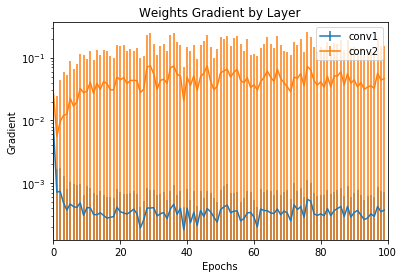

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:21: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


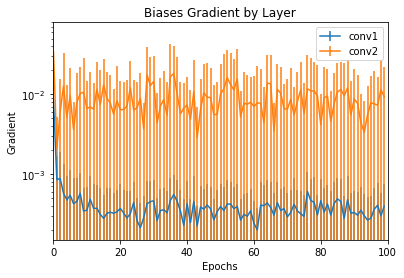

In [8]:
# Plotting gradients
x = np.arange(epochs)
i = 0
plt.hold(True)
while i < len(tf.trainable_variables()):
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.hold(False)
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.hold(True)
while i < len(tf.trainable_variables()):
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.hold(False)
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"])
plt.xlim(-0.2, epochs)
plt.show()